In [2]:
!wget https://storage.googleapis.com/quickdraw_dataset/full/simplified/rabbit.ndjson
!wget https://storage.googleapis.com/quickdraw_dataset/full/simplified/dog.ndjson    
!wget https://storage.googleapis.com/quickdraw_dataset/full/simplified/cat.ndjson
!wget https://storage.googleapis.com/quickdraw_dataset/full/simplified/elephant.ndjson        
!wget https://storage.googleapis.com/quickdraw_dataset/full/simplified/bird.ndjson      

--2024-05-05 14:23:11--  https://storage.googleapis.com/quickdraw_dataset/full/simplified/rabbit.ndjson
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99669519 (95M) [application/octet-stream]
Saving to: 'rabbit.ndjson'

rabbit.ndjson       100%[===================>]  95.05M  59.0MB/s    in 1.6s    

2024-05-05 14:23:13 (59.0 MB/s) - 'rabbit.ndjson' saved [99669519/99669519]

--2024-05-05 14:23:14--  https://storage.googleapis.com/quickdraw_dataset/full/simplified/dog.ndjson
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 173.194.202.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91290615 (87M) [application/octe

In [3]:
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import ast
from PIL import Image, ImageDraw
import h5py

2024-05-05 14:23:29.858200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 14:23:29.858333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 14:23:30.018123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in strokes:
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i],
                             stroke[1][i],
                             stroke[0][i+1],
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((64, 64))
#     image = image.convert(mode='RGB')
    image_array = np.array(image) / 255.  # Convert to NumPy array and normalize
    return image_array

In [5]:
paths = ['cat.ndjson', 'dog.ndjson', 'rabbit.ndjson', 'elephant.ndjson', 'bird.ndjson']

In [6]:
def load_ndjson(file_path):
    drawings = []
# Open the ndjson file
    with open(file_path, 'r') as file:
        # Read each line
        for line in file:
            # Parse JSON from each line
            data = json.loads(line)
            if data['recognized'] == True:
                drawings.append(data)
    return drawings

In [7]:
data = []

for path in paths:
  draws = load_ndjson(path)
  data.extend(draws)
    
draw_df = pd.DataFrame(data)[['word', 'drawing']]
del data
del draws

In [9]:
shuffled_df = draw_df.sample(frac=1, random_state=42)  # Set random_state for reproducibility

chosen_samples = []
samples_no = 80000 
cat_sample = shuffled_df[shuffled_df['word'] == 'cat'].head(samples_no)
dog_sample = shuffled_df[shuffled_df['word'] == 'dog'].head(samples_no)
rabbit_sample = shuffled_df[shuffled_df['word'] == 'rabbit'].head(samples_no)
ele_sample = shuffled_df[shuffled_df['word'] == 'elephant'].head(samples_no)
bird_sample = shuffled_df[shuffled_df['word'] == 'bird'].head(samples_no)


chosen_samples.append(cat_sample)
chosen_samples.append(dog_sample)
chosen_samples.append(rabbit_sample)
chosen_samples.append(ele_sample)
chosen_samples.append(bird_sample)


# Concatenate the chosen samples into a single DataFrame
draw_df = pd.concat(chosen_samples, ignore_index=True)

del chosen_samples
del shuffled_df
del cat_sample
del dog_sample
del ele_sample
del bird_sample
del rabbit_sample

In [10]:
trainarray = draw_df['drawing'].map(draw_it)
labels = np.array(draw_df['word'])

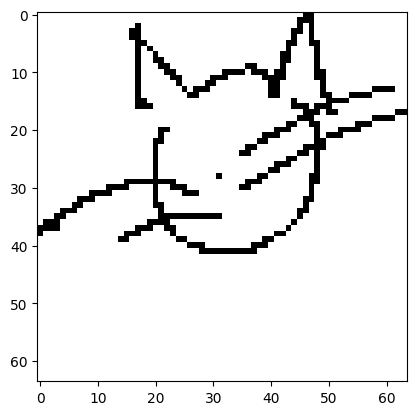

In [16]:
plt.imshow(trainarray[2], cmap='gray')

In [9]:
tensor = np.zeros((trainarray.shape[0],64,64))
for idx, i in enumerate(trainarray):
    tensor[idx] = i

del trainarray
del draw_df

In [11]:
from keras.utils import to_categorical

target = []
for i in labels:
    if i == 'cat':
        target.append(0)
    elif i == 'dog':
        target.append(1)
    elif i == 'rabbit':
        target.append(2)
    elif i == 'elephant':
        target.append(3)
    else:
        target.append(4)
target = np.array(target)
target = to_categorical(target)
del labels

In [12]:
tensor = np.reshape(tensor, (len(tensor), 64, 64, 1))

In [13]:
from sklearn.model_selection import train_test_split

# Performing train-test split for model training
X_train, X_dev, y_train, y_dev = train_test_split(tensor,
                                                    target,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify = target)

X_dev, X_test, y_dev, y_test = train_test_split(X_dev,
                                                    y_dev,
                                                    test_size=0.50,
                                                    random_state=42,
                                                    )

In [14]:
print(X_train.shape)
print(X_test.shape)
print(X_dev.shape)

(320000, 64, 64, 1)
(40000, 64, 64, 1)
(40000, 64, 64, 1)


In [15]:
del tensor
del target
import gc
gc.collect()

0

In [16]:
def data_generator(data,labels, batch_size):
    num_samples = len(data)
    while True:
      indices =  np.random.permutation(num_samples)
      for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            # x_batch = data[batch_indices]
            # y_batch = labels[batch_indices]
            x_batch = tf.convert_to_tensor(data[batch_indices], dtype=tf.float32)
            y_batch = tf.convert_to_tensor(labels[batch_indices], dtype=tf.int32)

            yield x_batch, y_batch

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [18]:
datagen = ImageDataGenerator(
#     rotation_range = 20,
    # zoom_range = 0.2,
    width_shift_range= 0.4,
    # height_shift_range = 0.7,
    shear_range = 0.9,
    fill_mode='constant',
    cval=1,
    horizontal_flip = True
)
testgen = ImageDataGenerator(
    horizontal_flip = True
)

In [19]:
# X_train = np.reshape(X_train,  (len(X_train), 64, 64, 1))
# X_dev = np.reshape(X_dev,  (len(X_dev), 64, 64, 1))
batch = 64

steps_per_epoch = len(X_train) // batch

# Define validation steps for validation data
validation_steps = len(X_dev) // batch

train_data_generator = datagen.flow(X_train, y_train, batch_size=batch)
validation_data_generator = testgen.flow(X_dev, y_dev, batch_size=batch)

In [20]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate
from keras.models import Model

In [21]:
inputs = Input(shape=(64,64,1))

x = Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
# x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x) 

x = Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x1 = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D((2,2))(x1)

x1 = Conv2D(256, (3,3), padding='same', activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = MaxPooling2D((2,2))(x1)

x2 = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((2,2))(x2)

x2 = Conv2D(256, (3,3), padding='same', activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)
x2 = MaxPooling2D((2,2))(x2)

x = concatenate([x1, x2])

x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)

outputs = Dense(5, activation='softmax')(x)

model = Model(inputs = inputs, outputs=outputs)
# model.summary()

In [22]:
from tensorflow.keras.optimizers import Adam

# Define your learning rate
learning_rate = 0.0001  # Example learning rate
# 0.0001
# Create Adam optimizer with custom learning rate
optimizer = Adam(learning_rate=learning_rate)

In [23]:
from keras.callbacks import LearningRateScheduler
import math

# Define a function to decay the learning rate
def lr_schedule(epoch):
    initial_lr = 0.001
    decay = 0.10
    epochs_drop = 10
    lr = initial_lr * math.pow(decay, math.floor((1+epoch)/epochs_drop))
    return lr

# Define the learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(train_data_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          validation_data=validation_data_generator,
          validation_steps=validation_steps,
          callbacks = [lr_scheduler]
          )

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   2/5000 ━━━━━━━━━━━━━━━━━━━━ 4:21 52ms/step - accuracy: 0.1914 - loss: 2.3386   

I0000 00:00:1714836271.814643     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714836271.839154     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7646 - loss: 0.6280

W0000 00:00:1714836434.531441     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 186s 34ms/step - accuracy: 0.7646 - loss: 0.6279 - val_accuracy: 0.8730 - val_loss: 0.3477 - learning_rate: 0.0010
Epoch 2/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/40


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 170s 34ms/step - accuracy: 0.8698 - loss: 0.3538 - val_accuracy: 0.7085 - val_loss: 7.9236 - learning_rate: 0.0010
Epoch 4/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 169s 34ms/step - accuracy: 0.8845 - loss: 0.3136 - val_accuracy: 0.8361 - val_loss: 0.4616 - learning_rate: 0.0010
Epoch 6/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 169s 34ms/step - accuracy: 0.8931 - loss: 0.2924 - val_accuracy: 0.8636 - val_loss: 0.4001 - learning_rate: 0.0010
Epoch 8/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/40
5000/5000 ━━━━━━━━━

In [25]:
model.evaluate(X_test, y_test)

  32/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9395 - loss: 0.1699

W0000 00:00:1714839678.464070     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9418 - loss: 0.1611


[0.16108395159244537, 0.9423750042915344]

/tmp/ipykernel_34/2504911515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_34/2504911515.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


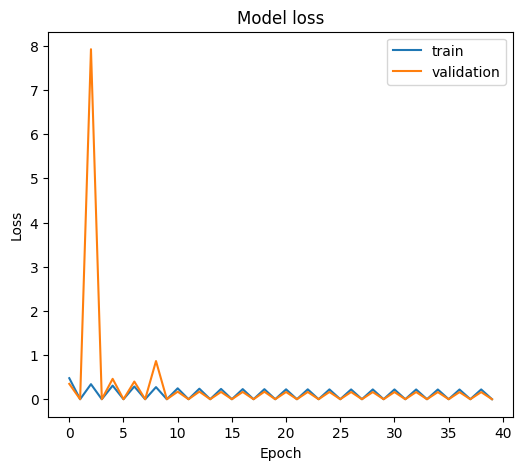

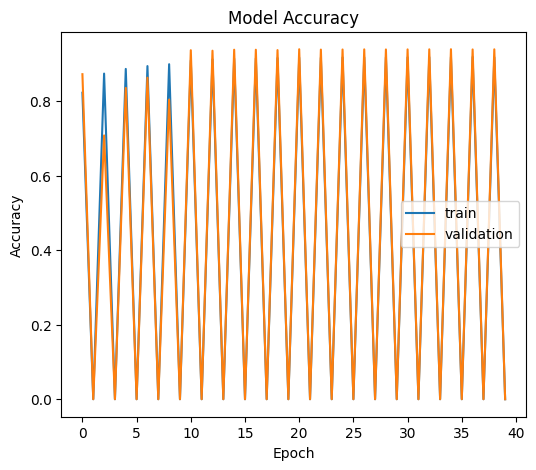

In [26]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,5)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,5)).set(xlabel='Epoch',ylabel='Accuracy')

plt.show()

In [27]:
y_pred = model.predict(X_test)

  28/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step 

W0000 00:00:1714839706.918771     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


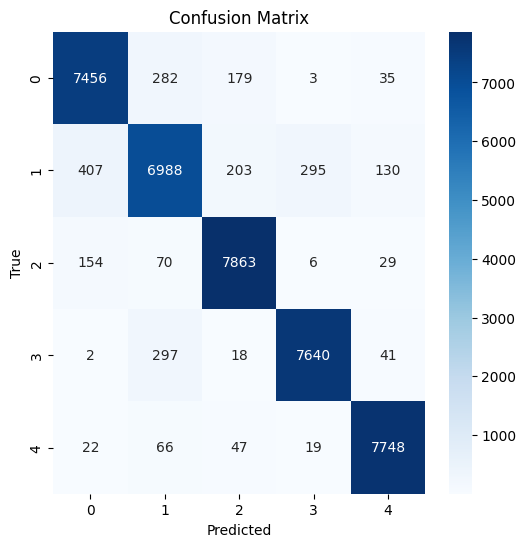

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
model.save("animal-doodle-classifier.h5")